In [2]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(1332)

In [3]:
# embedding matrix and layer
# first define an dummy input of shape => (B_S, time_steps,) i.e (N, L)
# assume a vocabulary of size => 50_000, and a max_seq_len => 256 (everything is dummy !!)
x = np.random.randint(low=0, high=50_000, size=(4, 256)) 
W_e = np.random.normal(size=(50_000, 512)) # embed_dim = 512


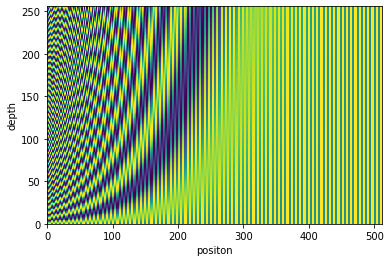

In [4]:
# positional encoding
# positonal encoding matrix ==> (sequence_length, depth)
xv, yv = np.meshgrid(np.arange(256), np.arange(512), sparse=False, indexing='ij')

W_p = np.where(
    yv % 2 != 0,
    np.cos(xv / 10000 ** (yv / 512)),
    np.sin(xv / 10000 ** (yv / 512))
)

plt.pcolormesh(W_p)
plt.xlabel("positon")
plt.ylabel("depth")
plt.show()

In [5]:
# self-attention using bidirectional mask single head
# here lets consider the model_dim = embed_dim = attention_dim = 512
# construction of the Query, key and value weight matrices

# query
W_q = np.random.randn(512, 512)  # (embed_dim, model_dim)
b_q = np.random.randn(512)

#key
W_k = np.random.randn(512, 512) 
b_k = np.random.randn(512, )

#value
W_v = np.random.randn(512, 512) # (embed_dim, out_dim / model_dim)
b_v = np.random.randn(512,)


x_p = W_e[x] + W_p
# print(x.shape, W_q.shape)

Q = x_p @ W_q + b_q
K = x_p @ W_k + b_k
V = x_p @ W_v + b_v

# print(K.shape, K.T.shape)
attention_logits = Q @ np.transpose(K, [0, 2, 1]) / np.sqrt(512)  # QxK.T / sqrt(dim)
# softmax the outputs
attention_weights = np.exp(
    attention_logits - np.amax(attention_logits, axis=-1, keepdims=True)
    ) / np.exp(
        attention_logits - np.amax(attention_logits, axis=-1, keepdims=True)
        ).sum(axis=-1, keepdims=True)
# print(attention_weights.shape)

# Q = np.einsum("ijk, kd->ijk", x, W_q) + b_q  # the einsum way
# print(Q.shape)

attention_out = attention_weights @ V
print(attention_out.shape)

# if a mask especially unidirectional is incl, construct an lower tri matrix
mask = np.tril(np.ones((256, 256)))
mask = np.where(mask == 0, -np.inf, 0)

attention_logits_masked = attention_logits + mask    # used for the decoder

(4, 256, 512)


In [6]:
# final out layer
# the weights for the final layer will have shape (model_dim, vocab_size)
# the final layer predicts a probability distribution over the whole vocabulary
W_ff = np.random.randn(512, 50_000)
b_ff = np.random.randn(50_000,)
final_out = attention_out @ W_ff + b_ff

print(final_out.shape)

(4, 256, 50000)


# **GPT algorithm !!**
*Building a GPT model using the above parameters and construting a step by step algorithm*





In [7]:
# making the Generative Pretrained transformer !!
# visualizing getting the target and the inputs first
x_new = np.random.randint(low=0, high=50_000, size=(4, 256 + 1)) # max_len + 1
x_in  =  x_new[:, : -1]
x_target = x_new[:, 1: ] # shifting x by one position to emulate the language modelling task i.e. pred the next word in the sequence

print(x_in.shape)

(4, 256)


In [14]:
# init the weights for each self-attention block and all the other parameters
params = {}
num_attention_layers = 6

params["embed"] = (np.random.randn(50_000, 512))
for head in range(num_attention_layers):
  params[f"Q_{head}"] = (
      np.random.randn(512, 512),  # (embed_dim, model_dim)
      np.random.randn(512)
  )
  params[f"K_{head}"] = (
     np.random.randn(512, 512),  # (embed_dim, model_dim)
     np.random.randn(512)
  )
  params[f"V_{head}"] = (
      np.random.randn(512, 512),  # (embed_dim, model_dim)
      np.random.randn(512)
  )

params["ff"] = (
    np.random.randn(512, 50_000),
    np.random.randn(50_000)
)

print(params.keys())

dict_keys(['embed', 'Q_0', 'K_0', 'V_0', 'Q_1', 'K_1', 'V_1', 'Q_2', 'K_2', 'V_2', 'Q_3', 'K_3', 'V_3', 'Q_4', 'K_4', 'V_4', 'Q_5', 'K_5', 'V_5', 'ff'])


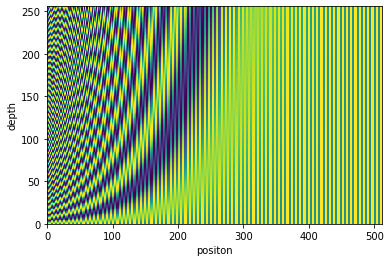

(4, 256, 50000)


In [16]:
# the GPT algorithm 
# GPT is a decoder only transformer model for language modelling
# it utilizes masked self attention and is trained to predict the probability of next word in a sequence

# using the defined weight values
# positional encoding
xv, yv = np.meshgrid(np.arange(256), np.arange(512), indexing="ij")
pos_en = np.where(
    yv % 2 == 0,
    np.sin(xv / 10_000 ** (yv / 512)),
    np.cos(xv / 10_000 ** (yv / 512))
)
# verify the pos encoding
# plt.pcolormesh(pos_en)
# plt.xlabel("positon")
# plt.ylabel("depth")
# plt.show()

pos_x = params["embed"][x_in] + pos_en

# creation of the q,k,v and splitting them into n_heads and calculating attention

for n in range(num_attention_layers):
  q = pos_x @ params[f"Q_{n}"][0] + params[f"Q_{n}"][1] 
  k = pos_x @ params[f"K_{n}"][0] + params[f"K_{n}"][1]
  v = pos_x @ params[f"V_{n}"][0] + params[f"V_{n}"][1]

  # split 
  q = q.reshape((4, -1, 8, 64))
  q = np.transpose(q, [0, 2, 1, 3])

  k = k.reshape((4, -1, 8, 64))
  k = np.transpose(k, [0, 2, 1, 3])

  v = v.reshape((4, -1, 8, 64))
  v = np.transpose(v, [0, 2, 1, 3])

  # print(q.shape)
  attention_logits = q @ np.transpose(k, [0, 1, 3, 2]) / np.sqrt(512)   # QxK.T / sqrt(dim)
  # add the attention mask (unidirectional)
  mask = np.tril(np.ones((256, 256)))
  attention_mask = np.where(mask == 0, -np.inf, 0.)
  attention_logits = attention_logits + attention_mask
  # softmax the outputs
  attention_weights = np.exp(
      attention_logits - np.amax(attention_logits, axis=-1, keepdims=True)
      ) / np.exp(
          attention_logits - np.amax(attention_logits, axis=-1, keepdims=True)
          ).sum(axis=-1, keepdims=True)

  attention_out = attention_weights @ v

  concat_head_out = np.transpose(attention_out, [0, 2, 1, 3]).reshape(4, -1, 512)
  # adding dropout with a certain probability
  # add dropout
  # add 
  pos_x = pos_x + concat_head_out
# and layer normalize
# after layernormalization add a feed_forward layer 
final_out_logits = pos_x @ params["ff"][0] + params["ff"][1]

print(final_out_logits.shape)